In [1]:
# Example: Robust spin test demo with error reporting and diagnostic checks
# This needs to use the conda environment with enigmatoolbox installed (lami)
# It appears that the enigma toolbox depends on multiple dependencies and therefore just installing enigmatoolbox
# does not work. So use this code to perform the spin test
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from enigmatoolbox.permutation_testing import spin_test

# Load using numpy.load instead of pickle
tmp_x = np.load('tmp/total_grad_masked.npy', allow_pickle=True)
tmp_y = np.load('tmp/total_ap_masked.npy', allow_pickle=True)
#the spin_test handles NaN as it uses Pandas corrcoef. Since we are using only the left hemisphere, we need to add NaN to the right hemisphere
tmp_x = np.concatenate((tmp_x, np.full(len(tmp_x), np.nan)))
tmp_y = np.concatenate((tmp_y, np.full(len(tmp_y), np.nan)))
p_spin, null_dist = spin_test(
    tmp_x, 
    tmp_y, 
    n_rot=1000, #default is 1000
    surface_name='fsa5',#
    parcellation_name='schaefer_400',#they have options for this (as shown from the source code)
    type='spearman',
    null_dist=True
)

print(p_spin)
print(null_dist)
plt.hist(null_dist,bins=100)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000


KeyboardInterrupt: 

In [61]:
print(tmp_y.shape)

(400,)


In [ ]:

from brainspace.null_models import SpinPermutations
from brainspace.datasets import load_gradient, load_marker, load_conte69
import nibabel as nib
from neuromaps import datasets, images, nulls, resampling

from nilearn.datasets import fetch_atlas_schaefer_2018
sc = fetch_atlas_schaefer_2018(n_rois=400,yeo_networks=7)
#form labels remove any item with 'RH'
labels = [item for item in sc['labels'] if b'RH' not in item]
print(len(labels))
rotated = nulls.alexander_bloch(neurosynth_parc, atlas='fsaverage', density='10k',
                                n_perm=100, seed=1234, parcellation=parcellation)


200


In [ ]:
# --- Parameters block: set all user-controlled parameters here ---

hcp_save_subpath = 'HCP'
exvivo_save_subpath = 'EXVIVO'
hemi = 'lh'# lh or rh
G_sparsity = 0.9
hcp_grad_file = f'{hcp_save_subpath}/hcp_template_grad_{hemi}_sparsity_{G_sparsity}.npy'
npz_path = f'{exvivo_save_subpath}/grad_algnd2_total_grad_{hemi}_sparsity_{G_sparsity}.npz'

#metric_labels = ['Total', 'Supra', 'Infra','Supra/Total','Infra/Total']  # Can be any length
bar_width = 0.12
colormap_name = 'tab20'
ylim_min = -0.5
ylim_max = 0.5
font_size = 16
ncomp = 3 #number of components to plot ; if not specified, all will be plotted

#for spin test
number_of_rotations = 1
# ---------------------------------------------------------------

# Load HCP gradient maps and calculate spatial similarity
if os.path.exists(hcp_grad_file):
    #load hcp data 
    hcp_tmpl = np.load(hcp_grad_file)#this is 32k flsr space
    
    with np.load(npz_path, allow_pickle=True) as data:
        arrays = data['arrays']
        labels = data['labels']
        exvivo_grad_names = data['metrics']
        exvivo_grads = list(zip(arrays, labels, exvivo_grad_names))

    print(exvivo_grad_names)

    #this should be in the exact order of the exvivo_grad_names
    # this is 32k flsr space
    exvivo_grad_arrays = [
        exvivo_grads[0][0], #total
        exvivo_grads[1][0], #supra
        exvivo_grads[2][0], #infra
        exvivo_grads[3][0], #supra/total
        exvivo_grads[4][0], # Note: "Infra/Total" index must match data
        exvivo_grads[5][0], # Note: "Supra/Total" index must match data
    ]
    

    grad_dict = dict(zip(exvivo_grad_names, exvivo_grad_arrays))

    # --- Compute spatial correlations between ex vivo and HCP gradients --- 
    calc_corrs = []
    for grad_name, grad_arr in grad_dict.items():
        # Calculate the spatial correlation (Pearson) between components for ex vivo and HCP
        n_comp = grad_arr.shape[1]
        n_comp_hcp = hcp_tmpl.shape[1]
        min_n = min(n_comp, n_comp_hcp)
        # Trim to the minimum number of components present in both sets
        corrs = np.diag(np.corrcoef(grad_arr[:, :min_n].T, hcp_tmpl[:, :min_n].T)[:min_n, min_n:])
        calc_corrs.append((grad_name, corrs))
    
    # --- Compute spin test p-values for each set of correlations ---
    spin_results = []
    for grad_name, grad_arr in grad_dict.items():
        n_comp = grad_arr.shape[1]
        n_comp_hcp = hcp_tmpl.shape[1]
        min_n = min(n_comp, n_comp_hcp)
        p_spin_vec = []
        null_dists = []
        for i in range(min_n):
            # 
            # 
            # 
            # 
            # 
            #  expects 1D input vectors (corresponding surface vertex maps)
            p_spin, null_dist = spin_test(
                grad_arr[:, i], 
                hcp_tmpl[:, i], 
                n_rot=number_of_rotations, 
                surface_name='fsa5',
                parcellation_name='schaefer_400',
                type='spearman', 
                null_dist=True
            )

            p_spin_vec.append(p_spin)
            null_dists.append(null_dist)
        spin_results.append({
            'grad_name': grad_name,
            'p_spin': np.array(p_spin_vec),
            'null_dist': null_dists
        })


    

In [6]:
print(spin_results)

NameError: name 'spin_results' is not defined

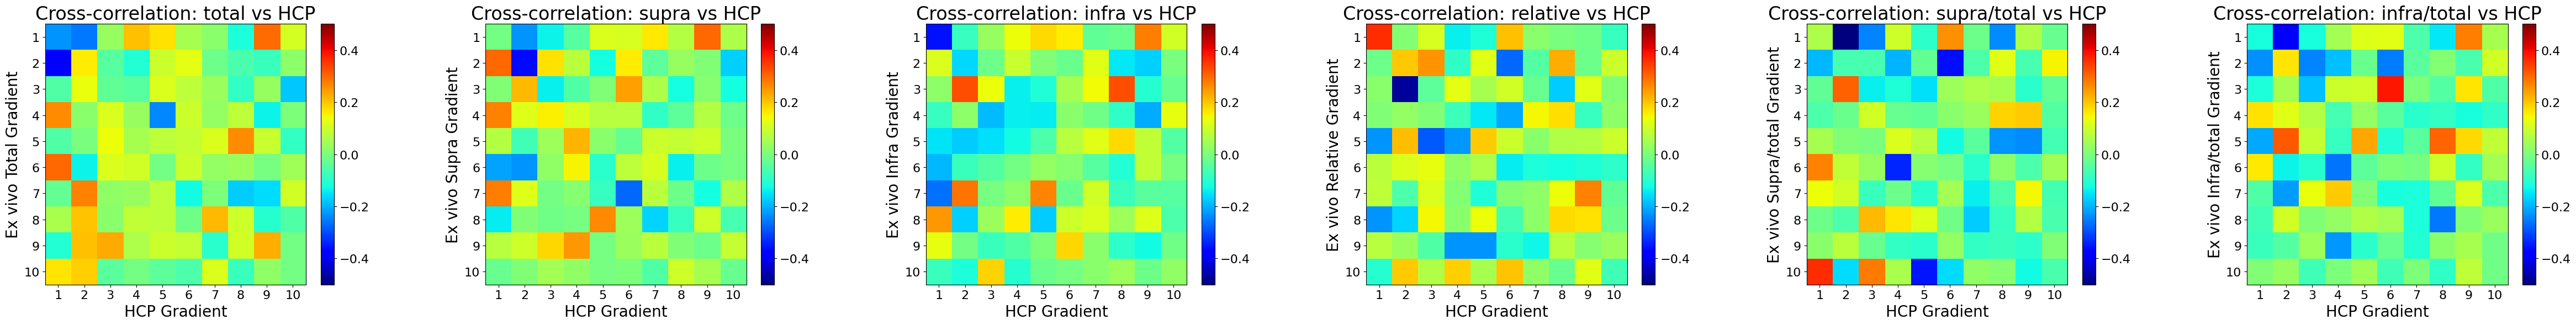

In [3]:
# Plot all cross-correlation matrices in a single figure, in a single row
num_grads = len(grad_dict)
fig, axes = plt.subplots(1, num_grads, figsize=(8*num_grads, 6), squeeze=False)

# Set font size parameters
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 16
cbar_label_fontsize = 18
colormap = 'jet'
for idx, (grad_name, grad_arr) in enumerate(grad_dict.items()):
    n_comp = grad_arr.shape[1]
    n_comp_hcp = hcp_tmpl.shape[1]
    min_n = min(n_comp, n_comp_hcp)
    # Compute full cross-correlation matrix between ex vivo and HCP gradients
    corrs = np.corrcoef(grad_arr[:, :min_n].T, hcp_tmpl[:, :min_n].T)[:min_n, min_n:]
    ax = axes[0, idx]
    im = ax.imshow(corrs, cmap=colormap, vmin=-0.5, vmax=0.5)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Increase colorbar tick labels and, if needed, label font size
    cbar.ax.tick_params(labelsize=tick_fontsize)
    # Optionally, set cbar label font size if you add a label
    # cbar.set_label('Correlation', fontsize=cbar_label_fontsize)
    ax.set_title(f'Cross-correlation: {grad_name} vs HCP', fontsize=title_fontsize)
    ax.set_xlabel('HCP Gradient', fontsize=label_fontsize)
    ax.set_ylabel(f'Ex vivo {grad_name.capitalize()} Gradient', fontsize=label_fontsize)
    ax.set_xticks(range(min_n), [f'{i+1}' for i in range(min_n)], fontsize=tick_fontsize)
    ax.set_yticks(range(min_n), [f'{i+1}' for i in range(min_n)], fontsize=tick_fontsize)
    # Increase tick parameters directly (in case some backends ignore fontsize in set_xticks)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

In [4]:

import numpy as np
from statsmodels.stats.multitest import multipletests

def fdr_correction(p_values_dict, alpha=0.05):
    """
    Apply FDR correction (Benjamini-Hochberg) across all metrics.
    
    Parameters:
    -----------
    p_values_dict : dict
        Dictionary with metric names as keys and p-value arrays as values
    alpha : float
        Significance level (default: 0.05)
    
    Returns:
    --------
    corrected_dict : dict
        Dictionary with same structure, containing corrected p-values
    """
    # Flatten all p-values
    all_p_values = np.concatenate([p_vals for p_vals in p_values_dict.values()])
    
    # Apply FDR correction
    _, p_corrected, _, _ = multipletests(all_p_values, alpha=alpha, method='fdr_bh')
    
    # Reshape back to original structure
    corrected_dict = {}
    idx = 0
    for metric, p_vals in p_values_dict.items():
        n_vals = len(p_vals)
        corrected_dict[metric] = p_corrected[idx:idx+n_vals]
        idx += n_vals
    
    return corrected_dict

    p_corrected_dict = fdr_correction(spin_pvals_dict)
    print(p_corrected_dict)


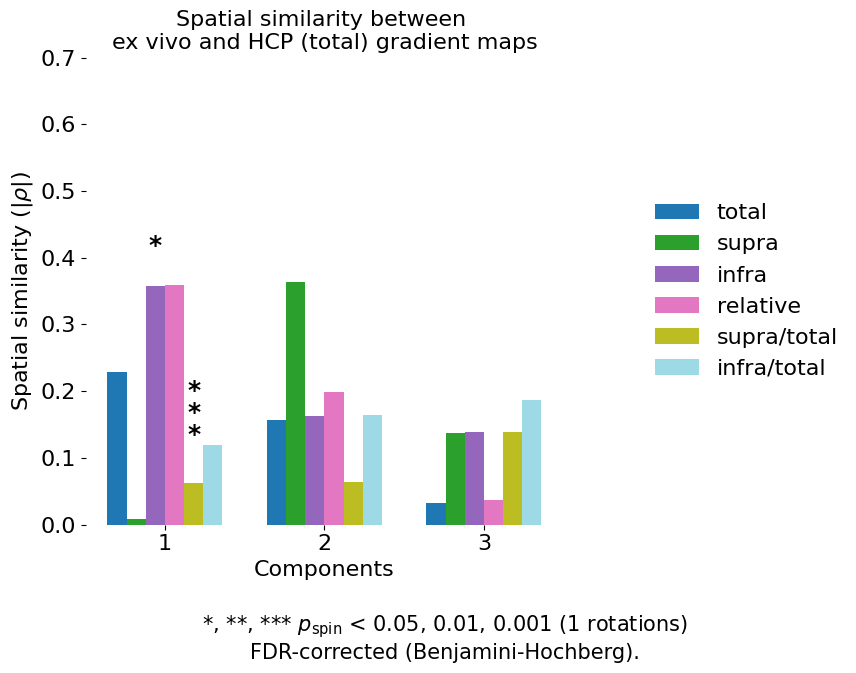

In [5]:
# Truncate to min(len(calc_corrs), len(metric_labels)) in case metric_labels or corrs is changed
max_len = min(len(exvivo_grad_names), len(calc_corrs))
corr_diags = [(exvivo_grad_names[i], calc_corrs[i][1]) for i in range(max_len)]
ncomp = 3
ALPHA = 0.05
# Gather spin p-values per gradient for annotation

import os
import pickle

spin_pvals_path = f'{exvivo_save_subpath}/spin_pvals_dict_fdrcorrected_sparsity_{G_sparsity}.pkl'

if os.path.exists(spin_pvals_path):
    with open(spin_pvals_path, 'rb') as f:
        spin_pvals_dict = pickle.load(f)
else:
    spin_pvals_dict = {}
    for r in spin_results:
        spin_pvals_dict[r['grad_name']] = r['p_spin']
    spin_pvals_dict = fdr_correction(spin_pvals_dict)

if len(corr_diags) == 0:
    print("No correlation vectors specified, nothing to plot.")
else:
    # Determine the number of components actually present; use the minimum length of any values vector
    if ncomp is not None:
        num_components = ncomp
    else:
        num_components = min(len(values) for _, values in corr_diags)
    x = np.arange(num_components)

    fig_height = max(4, max_len)
    fig, ax = plt.subplots(figsize=(num_components*3, fig_height))

    n_groups = len(corr_diags)
    offsets = (np.arange(n_groups) - (n_groups - 1) / 2) * bar_width

    cmap = cm.get_cmap(colormap_name)
    if n_groups > cmap.N:
        colors = [cmap(i / n_groups) for i in range(n_groups)]
    else:
        colors = cmap(np.linspace(0, 1, n_groups))

    # Calculate minimum p-value threshold based on number_of_rotations
    pval_min = 1.0 / number_of_rotations

    # Helper function to get significance string (asterisks) convention
    def significance_asterisks(pval):
        if pval < 0.001:
            return '***'
        elif pval < 0.01:
            return '**'
        elif pval < 0.05:
            return '*'
        else:
            return ''
    
    # For vertical asterisks, break asterisks into one per line
    def vertical_asterisks(sig):
        if sig == '':
            return ''
        return '\n'.join(list(sig))

    # To avoid overlapping asterisks, stagger y position for each group
    group_offsets_for_asterisks = np.linspace(0.01, 0.04, n_groups)  # Adjustable vertical offset for asterisks

    for idx, ((label, values), color) in enumerate(zip(corr_diags, colors)):
        bar_container = ax.bar(x + offsets[idx], abs(values[:num_components]), bar_width, label=label, color=color)
        # Get matching spin p-values for the label/gradient
        pvals = spin_pvals_dict.get(label, None)
        if pvals is not None:
            for comp_idx, rect in enumerate(bar_container):
                pval = pvals[comp_idx]
                sig = significance_asterisks(pval)
                if sig:  # If significant, annotate with asterisk(s)
                    height = rect.get_height()
                    # Offset y position for asterisks to reduce overlap by group
                    v_offset = 0.02 + group_offsets_for_asterisks[idx]
                    y_text = height + v_offset
                    ax.text(
                        rect.get_x() + rect.get_width() / 2., y_text,
                        vertical_asterisks(sig),
                        ha='center', va='bottom',
                        fontsize=font_size + 2,
                        color='black', fontweight='bold',
                        zorder=10,
                        linespacing=0.9    # linespacing helps keep things compact
                    )
                # Optionally, annotate the lowest possible p (optional for clarity)
                # elif pval < pval_min:
                #     height = rect.get_height()
                #     y_text = height + 0.01
                #     ax.text(
                #         rect.get_x() + rect.get_width() / 2., y_text,
                #         f"< {1.0/number_of_rotations:.2g}",
                #         ha='center', va='bottom',
                #         fontsize=font_size-2,
                #         color='black', fontweight='normal'
                #     )

    ax.set_xlabel('Components', fontsize=font_size)
    ax.set_ylabel('Spatial similarity (|$\\rho$|)', fontsize=font_size)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i+1}' for i in x], fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size, left=False)
    # Put the legend outside the plot to the right
    ax.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1.15, 0.5), ncol=1, frameon=False)
    ax.set_title('Spatial similarity between \nex vivo and HCP (total) gradient maps', fontsize=font_size)
    #ax.set_ylim(ylim_min, ylim_max)
    #since absolute values are plotted, the ylim is 0 to 1
    ax.set_ylim(0, 0.7)
    
    # Add an extra note about asterisk convention and the spin test p-values
    # This can be a figure-level text placed below the plot
    fig.text(
        0.5, -0.03,
        r"*, **, *** $p_{\mathrm{spin}}$ < 0.05, 0.01, 0.001 (" + str(number_of_rotations) + r" rotations)" "\n" r"FDR-corrected (Benjamini-Hochberg).",
        ha='center', va='top', fontsize=font_size-1
    )

    # Remove all spines (box around plot)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='y', which='both', left=True, right=False)

    plt.tight_layout()
    plt.show()


#save spin_pvals_dict to the subpath of exvivo_save_subpath
with open(f'{exvivo_save_subpath}/spin_pvals_dict_fdrcorrected_sparsity_{G_sparsity}.pkl', 'wb') as f:
    pickle.dump(spin_pvals_dict, f)



In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import nibabel as nib
#load 
file_name =  '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/exc022/aseg.upsampled.mgz'
dat = nib.load(file_name)

#get the aseg labelsa


In [29]:
dat.header.get_zooms()

(0.12, 0.12, 0.12)

In [ ]:
mri_vol2vol \   
  --mov /Users/dennis.jungchildmind.org/Desktop/subcortical_test/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii \
  --targ /Users/dennis.jungchildmind.org/Desktop/subcortical_test/exc022/aseg.upsampled.mgz \
  --inv \
  --lta /Users/dennis.jungchildmind.org/Desktop/subcortical_test/exc022/transforms/talairach.xfm.lta \
  --o /Users/dennis.jungchildmind.org/Desktop/subcortical_test/exc022/Schaefer_Tian_in_native.mgz \
  --no-save-reg \
  --nearest


In [22]:
# downsample dat by 4
dat2 = dat.get_fdata()[::4, ::4, ::4]
# Set zeros in dat2 as nan
dat2[dat2 == 3] = np.nan
dat2[dat2 == 2]= np.nan
dat2[dat2 == 4] = np.nan
print(np.unique(dat2))
#cat $FREESURFER_HOME/FreeSurferColorLUT.txt | grep -i thal
#10 is left thalamus, 49 is right thalamus
print(dat2.shape)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# dat2 is the downsampled volumetric data with zeros set to nan
# Get the indices of non-nan voxels for visualization
coords = np.column_stack(np.where(~np.isnan(dat2)))


[ 7.  8. 10. 11. 12. 13. 16. 17. 18. 26. 28. 77. nan]
(160, 350, 400)


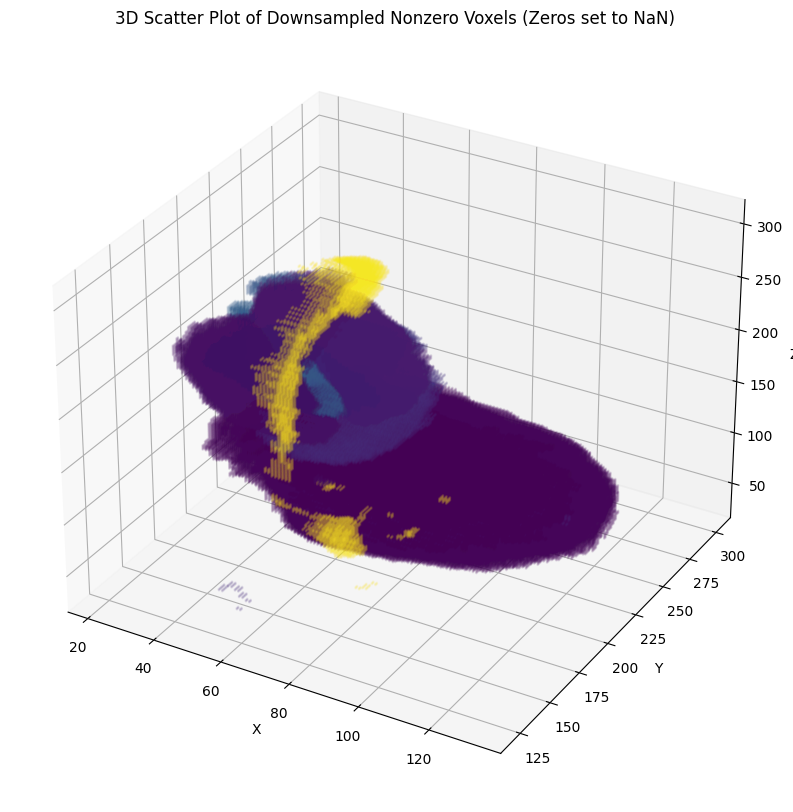

In [25]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# color the voxels by the value
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=dat2[coords[:, 0], coords[:, 1], coords[:, 2]], s=1, alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Downsampled Nonzero Voxels (Zeros set to NaN)')
plt.show()


In [ ]:

mni_volumetric = '/Users/dennis.jungchildmind.org/Desktop/subcortical_test/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_1mm.nii.gz'
c = nib.load(mni_volumetric)
print(c.get_fdata().shape)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Get the data
data = c.get_fdata()

# Find nonzero voxels for visualization
coords = np.column_stack(np.where(data > 0))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Color all points according to their data value (colormap normalized automatically).
values = data[coords[:, 0], coords[:, 1], coords[:, 2]]
scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=values, s=1, alpha=0.01, cmap='viridis')
plt.colorbar(scatter, ax=ax, pad=0.1, label='Data Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


    

In [ ]:
print(c.get_header())